# Time series forecasting
**V1: Single-step, single-output models**

A comparison between different prediction models

Based on: https://www.tensorflow.org/tutorials/structured_data/time_series

In [20]:
# Choose which feature to predict:
feature_out = "prod_solar"
# feature_out = "prod_wind"

In [21]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython
import IPython.display

sns.set_theme()

### Import data

In [22]:
df = pd.read_pickle("..\data\data_prepared.pkl")
df.head()


,prod_wind,prod_solar,day_sin,day_cos,year_sin,year_cos,solar_el,solar_el_clip
datetime,,,,,,,,
2020-01-01 00:00:00+00:00,6989.50,0.0,-7.670342e-12,1.000000,-2.150345e-03,0.999998,-60.949049,0.0
2020-01-01 01:00:00+00:00,7371.25,0.0,2.588190e-01,0.965926,-1.433564e-03,0.999999,-56.073363,0.0
2020-01-01 02:00:00+00:00,7447.75,0.0,5.000000e-01,0.866025,-7.167823e-04,1.000000,-48.553549,0.0
2020-01-01 03:00:00+00:00,7699.25,0.0,7.071068e-01,0.707107,1.964387e-15,1.000000,-39.725411,0.0
2020-01-01 04:00:00+00:00,7703.00,0.0,8.660254e-01,0.500000,7.167823e-04,1.000000,-30.389395,0.0


### Split the data
- 70% training
- 20% validation
- 10% test

In [23]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

In [24]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
# fit scaler to training data
scaler.fit(df_train)
# scale all sets according to train set, preserve data frames
df_train = pd.DataFrame(scaler.transform(df_train),
                        columns=df.columns, index=df_train.index)
df_val = pd.DataFrame(scaler.transform(df_val),
                        columns=df.columns, index=df_val.index)
df_test = pd.DataFrame(scaler.transform(df_test),
                        columns=df.columns, index=df_test.index)

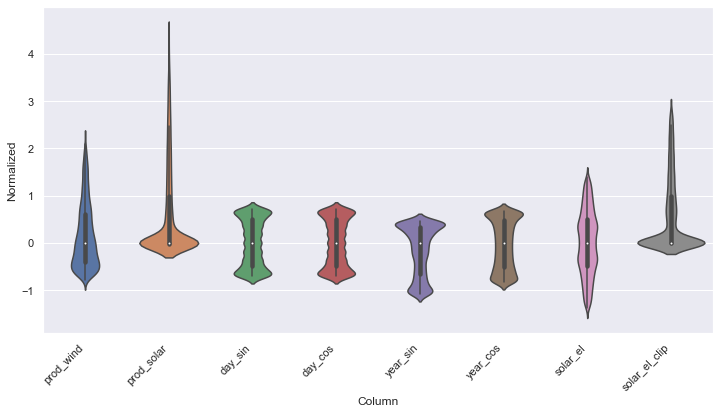

In [25]:
df_plot = df_train.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_plot)
_ = ax.set_xticklabels(df.keys(), rotation=45, ha='right')

What normalization?
More info and alternative scalers: https://scikit-learn.org/stable/modules/preprocessing.html

### Data Windowing
#### 1. Indexes and offsets

In [26]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=df_train, val_df=df_val, test_df=df_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

##### 2. Split

In [27]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

##### 3. Plot

In [28]:
def plot(self, model=None, plot_col=feature_out, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

#### 4. Create `tf.data.Datasets`

In [29]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [30]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### Single-step, single-output models

- Single-step models predict one time step in the future
- Single-output models predict one output feature
- The models have the same number of labels and inputs.

In [31]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[feature_out])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['prod_solar']

In [32]:
# create a wider window
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[feature_out])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['prod_solar']

In [33]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [34]:
wide_window.val

<MapDataset element_spec=(TensorSpec(shape=(None, 24, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>

#### Baseline model

- next value equal to current value
- not trainable

In [35]:
baseline = Baseline(label_index=column_indices[feature_out])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

109/109 [==============================] - 0s 1ms/step - loss: 0.1208 - mean_absolute_error: 0.2325


In [36]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 8)
Output shape: (32, 24, 1)


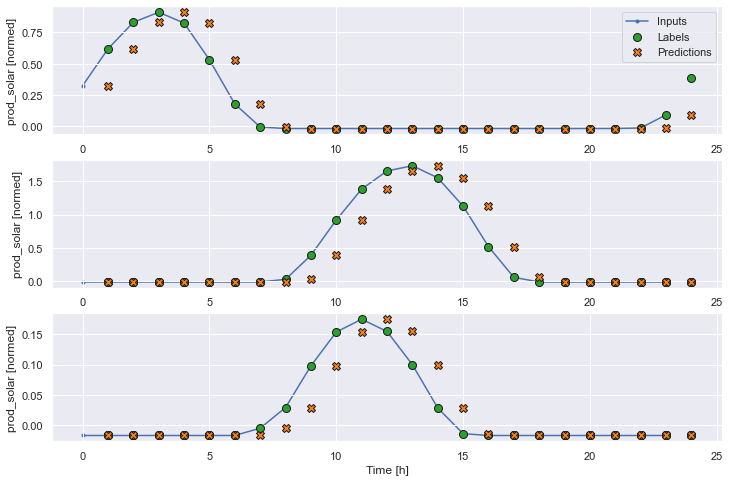

In [37]:
wide_window.plot(baseline)

In [38]:
# Training procedure for all models

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

#### Linear model
- linear transformation
- prediction only depends on one (last) time step
- if window is wider than one: multiple predictions with no interaction between them (the time axis acts like another batch axis)

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [40]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 8)
Output shape: (32, 24, 1)


In [41]:
history = compile_and_fit(linear, wide_window)

IPython.display.clear_output()
val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

109/109 [==============================] - 0s 517us/step - loss: 0.0527 - mean_absolute_error: 0.1776


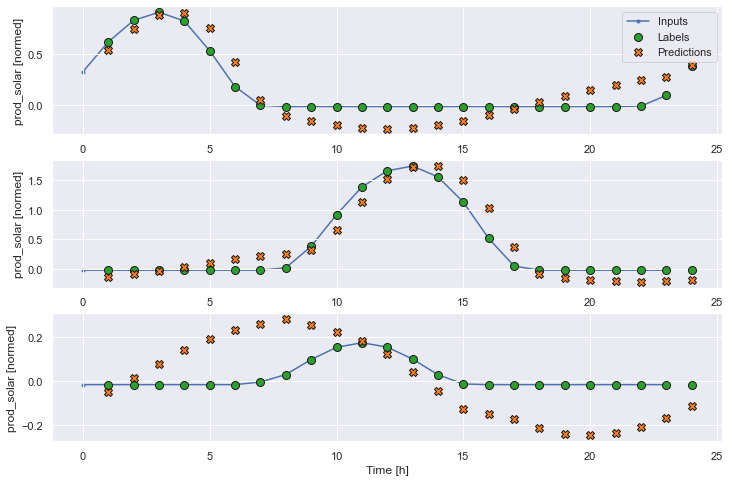

In [42]:
wide_window.plot(linear)

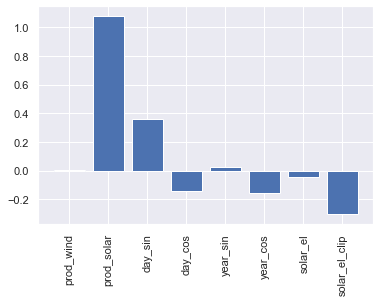

In [43]:
# plot weights
plt.bar(x = range(len(df_train.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(df_train.columns)))
_ = axis.set_xticklabels(df_train.columns, rotation=90)

#### Dense (single time step)
- like the `linear` model, but with several stacked `Dense` layers (deep neural network)

In [44]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, wide_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(wide_window.val)
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

109/109 [==============================] - 0s 648us/step - loss: 0.0043 - mean_absolute_error: 0.0421


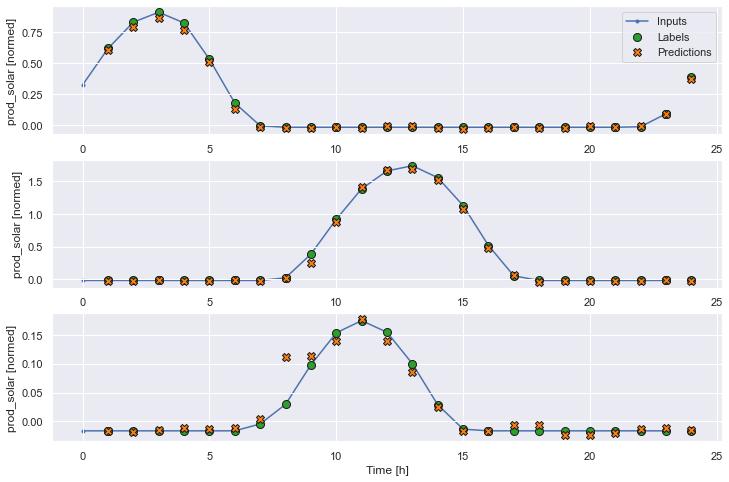

In [45]:
wide_window.plot(dense)

#### Multi-step dense
- Model predicts one time step into the future based on three time steps

In [46]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[feature_out])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['prod_solar']

In [47]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1])
])

In [48]:
print("Multi-step dense on `conv_window`:")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Multi-step dense on `conv_window`:
Input shape: (32, 3, 8)
Output shape: (32, 1, 1)


In [49]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

110/110 [==============================] - 0s 521us/step - loss: 0.0041 - mean_absolute_error: 0.0423


The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape.

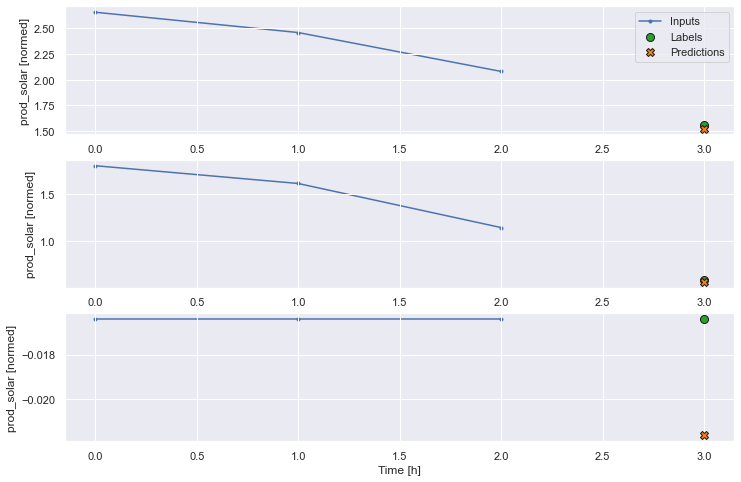

In [50]:
conv_window.plot(multi_step_dense)

#### Convolutional Neural Network
- Same model as `multi_step_dense`, but rewritten as CNN

In [51]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [52]:
print("Conv model on `conv_window`:")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`:
Input shape: (32, 3, 8)
Output shape: (32, 1, 1)


In [53]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

110/110 [==============================] - 0s 539us/step - loss: 0.0038 - mean_absolute_error: 0.0398


On `wide_window`, the input is shorter that output:

In [54]:
print("Conv model on `wide_window`:")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Conv model on `wide_window`:
Input shape: (32, 24, 8)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Fix the size difference between input and output with a modified window:

In [55]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[feature_out])

In [56]:
print("Conv model on `wide_conv_window`:")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Conv model on `wide_conv_window`:
Input shape: (32, 26, 8)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


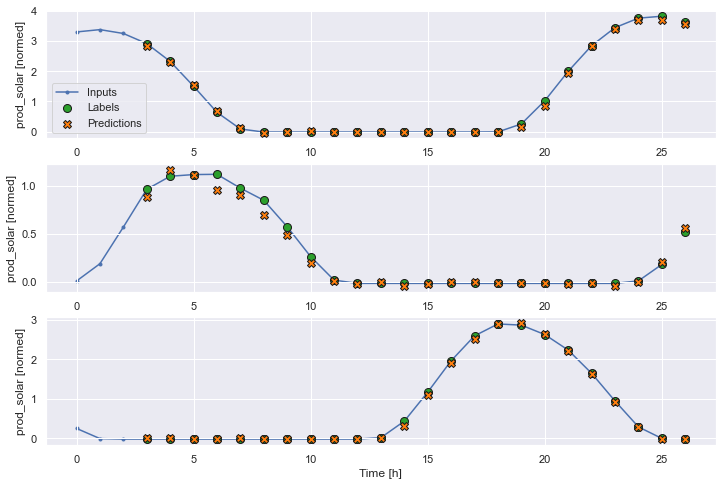

In [57]:
wide_conv_window.plot(conv_model)

#### Simple Recurrent Neural Network

- Recurrent Neural Networks (RNN) process a time series step-by-step
- The cell - a repeating block for each time step - is identical (each cell has the same weights and biases)
- It can be configured if the layer should produce an output or not:
    - If `return-sequences` is `False`: Layer only returns the output of the final time step
    - If `return-sequences` is `True`: Layer returns the output of all time steps

In [ ]:
srnn_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, rnn_units]
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', srnn_model(wide_window.example[0]).shape)

In [ ]:
history = compile_and_fit(srnn_model, wide_window)

IPython.display.clear_output()
val_performance['Simple RNN'] = srnn_model.evaluate(wide_window.val)
performance['Simple RNN'] = srnn_model.evaluate(wide_window.test, verbose=0)

In [ ]:
# wide_window.plot(srnn_model)

#### Gated Recurrent Unit (GRU) RNN

- `SimpleRNN` layer swapped for a `GRU` layer, otherwise the same

In [ ]:
gru_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(gru_model, wide_window)

IPython.display.clear_output()
val_performance['GRU'] = gru_model.evaluate(wide_window.val)
performance['GRU'] = gru_model.evaluate(wide_window.test, verbose=0)

In [ ]:
# wide_window.plot(gru_model)

#### Long Short-Term Memory (LSTM) RNN

- `GRU` layer swapped for an `LSTM` layer, otherwise the same

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [ ]:
# wide_window.plot(lstm_model)

#### Residual LSTM
- Knowledge that changes in time series are small gets implemented into model structure: The model predicts the value change instead of the value

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model, label_index=None):
    super().__init__()
    self.model = model
    self.label_index = label_index

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model
    if self.label_index is None:
      return inputs + delta
    # if single feature model, reduce input to desired feature
    inputs_single = inputs[:, :, self.label_index]
    return inputs_single[:, :, tf.newaxis] + delta

In [ ]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(units=1,
                              # The predicted deltas should start small.
                              # Therefore, initialize the output layer with zeros.
                              kernel_initializer=tf.initializers.zeros())
    ]),
    label_index=column_indices[feature_out])


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', residual_lstm(wide_window.example[0]).shape)

In [ ]:
history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

### Performance Comparison

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel(f'MAE [{feature_out}, normed]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45, ha='right')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name+":":17s} {value[1]:0.4f}')